<a href="https://colab.research.google.com/github/Ashvin7/pl-xg-ml/blob/main/04_ensemble_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Phase 4 — Ensemble Machine Learning Models (Random Forest + XGBoost)

**Goal:** Train non-linear models on engineered features to improve prediction vs Phase 3 baselines.

**Models**
- Random Forest Regressor
- XGBoost Regressor

**Evaluation**
- Regression: RMSE, MAE
- Ranking: Spearman, Kendall (on predicted points vs actual points per season)

**Split strategy**
- Chronological split by season (train older seasons, test most recent season).


In [2]:
import os

REPO_URL = "https://github.com/Ashvin7/pl-xg-ml.git"  # <-- change
REPO_DIR = "/content/pl-xg-ml"

if not os.path.exists(REPO_DIR):
    !git clone {REPO_URL} {REPO_DIR}

%cd {REPO_DIR}
!ls -la


Cloning into '/content/pl-xg-ml'...
remote: Enumerating objects: 40, done.
remote: Counting objects: 100% (40/40), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 40 (delta 15), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (40/40), 301.95 KiB | 9.74 MiB/s, done.
Resolving deltas: 100% (15/15), done.
/content/pl-xg-ml
total 820
drwxr-xr-x 5 root root   4096 Jan 27 20:56 .
drwxr-xr-x 1 root root   4096 Jan 27 20:56 ..
-rw-r--r-- 1 root root    901 Jan 27 20:56 01_eda.ipynb
-rw-r--r-- 1 root root 572643 Jan 27 20:56 01_phase1_data_prep.ipynb
-rw-r--r-- 1 root root  83645 Jan 27 20:56 02_feature_engineering.ipynb
-rw-r--r-- 1 root root 132138 Jan 27 20:56 03_baseline_models.ipynb
drwxr-xr-x 3 root root   4096 Jan 27 20:56 data
drwxr-xr-x 8 root root   4096 Jan 27 20:56 .git
-rw-r--r-- 1 root root   4688 Jan 27 20:56 .gitignore
drwxr-xr-x 2 root root   4096 Jan 27 20:56 notebooks
-rw-r--r-- 1 root root   5573 Jan 27 20:56 Phase_0_Project_SetUp.ipyn

In [3]:
import os, glob

DATA_PATH = "data/processed/phase2_model_dataset.csv"

print("CWD:", os.getcwd())
print("Exists?", os.path.exists(DATA_PATH))
print("Processed dir listing:", glob.glob("data/processed/*"))


CWD: /content/pl-xg-ml
Exists? True
Processed dir listing: ['data/processed/phase2_model_dataset.csv']


In [4]:
!pip -q install xgboost shap

In [5]:
import numpy as np
import pandas as pd

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor

from scipy.stats import spearmanr, kendalltau

from xgboost import XGBRegressor

In [6]:
df = pd.read_csv(DATA_PATH)

# Standardize column names
df.columns = [c.strip() for c in df.columns]

# Ensure season exists and is sortable
df["season"] = df["season"].astype(str)

df.head(), df.shape

(    season         team  season_start_year  season_idx  split  points  \
 0  2017-18      Arsenal               2017           0  train      63   
 1  2017-18  Bournemouth               2017           0  train      44   
 2  2017-18     Brighton               2017           0  train      40   
 3  2017-18      Burnley               2017           0  train      54   
 4  2017-18      Chelsea               2017           0  train      70   
 
    goal_diff  matches  goals_for  goals_against  points_per_match  \
 0         23       38         74             51          1.657895   
 1        -16       38         45             61          1.157895   
 2        -20       38         34             54          1.052632   
 3         -3       38         36             39          1.421053   
 4         24       38         62             38          1.842105   
 
    gd_per_match  xg_league  xga_league  xgd_league  xgd_per_match  xg_squad  \
 0      0.605263       68.3        47.8        20.5 

In [7]:
TARGET = "points"
ID_COLS = ["team", "season"]

# numeric candidates
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# Drop target from features
feature_cols = [c for c in num_cols if c != TARGET]

# OPTIONAL: if you have "rank" or "position" columns, drop them (leakage)
leak_like = [c for c in feature_cols if "rank" in c.lower() or "position" in c.lower() or "table" in c.lower()]
for c in leak_like:
    feature_cols.remove(c)

print("Target:", TARGET)
print("Num features:", len(feature_cols))
print("Leak-like removed:", leak_like)
feature_cols[:20]

Target: points
Num features: 14
Leak-like removed: []


['season_start_year',
 'season_idx',
 'goal_diff',
 'matches',
 'goals_for',
 'goals_against',
 'points_per_match',
 'gd_per_match',
 'xg_league',
 'xga_league',
 'xgd_league',
 'xgd_per_match',
 'xg_squad',
 'xg_per_match_squad']

In [8]:
seasons_sorted = sorted(df["season"].unique())
test_season = seasons_sorted[-1]
train_seasons = seasons_sorted[:-1]

train_df = df[df["season"].isin(train_seasons)].copy()
test_df  = df[df["season"] == test_season].copy()

X_train = train_df[feature_cols]
y_train = train_df[TARGET]

X_test = test_df[feature_cols]
y_test = test_df[TARGET]

print("Train seasons:", train_seasons)
print("Test season:", test_season)
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

Train seasons: ['2017-18', '2018-19', '2019-20', '2020-21', '2021-22', '2022-23', '2023-24']
Test season: 2024-25
Train shape: (140, 14) Test shape: (20, 14)


In [9]:
def rmse(y_true, y_pred):
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))

def regression_metrics(y_true, y_pred):
    return {
        "RMSE": rmse(y_true, y_pred),
        "MAE": float(mean_absolute_error(y_true, y_pred)),
    }

def ranking_metrics_by_season(df_season, pred_col="pred"):
    # Compare predicted points ranking vs actual points ranking within a season
    s = spearmanr(df_season[TARGET], df_season[pred_col]).correlation
    k = kendalltau(df_season[TARGET], df_season[pred_col]).correlation
    return float(s), float(k)

## Model 1 — Random Forest Regressor

We train a Random Forest baseline and evaluate on the most recent season.


In [10]:
rf = RandomForestRegressor(
    n_estimators=500,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)
pred_rf = rf.predict(X_test)

print("RF test regression metrics:", regression_metrics(y_test, pred_rf))


RF test regression metrics: {'RMSE': 1.4970756159927259, 'MAE': 0.5949}


In [11]:
rf_out = test_df[["season", "team", TARGET]].copy()
rf_out["pred_rf"] = pred_rf

s, k = ranking_metrics_by_season(rf_out, pred_col="pred_rf")
print(f"RF ranking metrics on {test_season}: Spearman={s:.3f}, Kendall={k:.3f}")

rf_out.sort_values("pred_rf", ascending=False).head(10)


RF ranking metrics on 2024-25: Spearman=0.997, Kendall=0.981


,season,team,points,pred_rf
151,2024-25,Liverpool,84,83.522
140,2024-25,Arsenal,74,74.082
152,2024-25,Manchester City,71,70.998
145,2024-25,Chelsea,69,68.996
154,2024-25,Newcastle Utd,66,66.186
141,2024-25,Aston Villa,66,65.900
155,2024-25,Nott'ham Forest,65,65.542
144,2024-25,Brighton,61,61.002
142,2024-25,Bournemouth,56,56.000
143,2024-25,Brentford,56,55.852


In [12]:
rf_imp = pd.DataFrame({
    "feature": feature_cols,
    "importance": rf.feature_importances_
}).sort_values("importance", ascending=False)

rf_imp.head(20)


,feature,importance
6,points_per_match,0.961297
2,goal_diff,0.015481
7,gd_per_match,0.012834
4,goals_for,0.003854
5,goals_against,0.001624
9,xga_league,0.000803
12,xg_squad,0.000744
11,xgd_per_match,0.000736
10,xgd_league,0.000688
1,season_idx,0.000630


## Model 2 — XGBoost Regressor

We train XGBoost with controlled tuning (small search) to avoid overfitting.


In [13]:
xgb = XGBRegressor(
    n_estimators=800,
    learning_rate=0.05,
    max_depth=3,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_alpha=0.0,
    reg_lambda=1.0,
    random_state=42,
    objective="reg:squarederror"
)

xgb.fit(X_train, y_train)
pred_xgb = xgb.predict(X_test)

print("XGB test regression metrics:", regression_metrics(y_test, pred_xgb))


XGB test regression metrics: {'RMSE': 1.2281125715951824, 'MAE': 0.6891420483589172}


In [14]:
xgb_out = test_df[["season", "team", TARGET]].copy()
xgb_out["pred_xgb"] = pred_xgb

s, k = ranking_metrics_by_season(xgb_out, pred_col="pred_xgb")
print(f"XGB ranking metrics on {test_season}: Spearman={s:.3f}, Kendall={k:.3f}")

xgb_out.sort_values("pred_xgb", ascending=False).head(10)


XGB ranking metrics on 2024-25: Spearman=0.999, Kendall=0.992


,season,team,points,pred_xgb
151,2024-25,Liverpool,84,83.741562
140,2024-25,Arsenal,74,74.003159
152,2024-25,Manchester City,71,71.146599
145,2024-25,Chelsea,69,69.046974
154,2024-25,Newcastle Utd,66,66.097809
141,2024-25,Aston Villa,66,65.430496
155,2024-25,Nott'ham Forest,65,63.863380
144,2024-25,Brighton,61,60.857414
142,2024-25,Bournemouth,56,56.574886
143,2024-25,Brentford,56,56.276447


## Controlled hyperparameter tuning (XGBoost)

Small grid, time-safe, avoids "overfitting by search."


In [15]:
param_grid = {
    "max_depth": [2, 3, 4],
    "learning_rate": [0.03, 0.05, 0.08],
    "subsample": [0.8, 0.9, 1.0],
    "colsample_bytree": [0.8, 0.9, 1.0],
}

xgb_base = XGBRegressor(
    n_estimators=800,
    random_state=42,
    objective="reg:squarederror"
)

grid = GridSearchCV(
    xgb_base,
    param_grid=param_grid,
    scoring="neg_root_mean_squared_error",
    cv=3,
    n_jobs=-1,
    verbose=1
)

grid.fit(X_train, y_train)
grid.best_params_, -grid.best_score_


Fitting 3 folds for each of 81 candidates, totalling 243 fits


({'colsample_bytree': 1.0,
  'learning_rate': 0.05,
  'max_depth': 3,
  'subsample': 1.0},
 np.float64(2.1373465855916343))

In [16]:
best_xgb = grid.best_estimator_
pred_xgb_tuned = best_xgb.predict(X_test)

print("Tuned XGB test regression metrics:", regression_metrics(y_test, pred_xgb_tuned))

xgb_tuned_out = test_df[["season", "team", TARGET]].copy()
xgb_tuned_out["pred_xgb_tuned"] = pred_xgb_tuned

s, k = ranking_metrics_by_season(xgb_tuned_out, pred_col="pred_xgb_tuned")
print(f"Tuned XGB ranking metrics on {test_season}: Spearman={s:.3f}, Kendall={k:.3f}")

xgb_tuned_out.sort_values("pred_xgb_tuned", ascending=False).head(10)


Tuned XGB test regression metrics: {'RMSE': 0.9488699001194804, 'MAE': 0.300814151763916}
Tuned XGB ranking metrics on 2024-25: Spearman=0.999, Kendall=0.992


,season,team,points,pred_xgb_tuned
151,2024-25,Liverpool,84,83.999802
140,2024-25,Arsenal,74,74.000107
152,2024-25,Manchester City,71,70.999832
145,2024-25,Chelsea,69,68.999748
141,2024-25,Aston Villa,66,66.000076
154,2024-25,Newcastle Utd,66,65.999916
155,2024-25,Nott'ham Forest,65,65.000565
144,2024-25,Brighton,61,61.000126
143,2024-25,Brentford,56,55.995827
142,2024-25,Bournemouth,56,55.995132


## SHAP explainability (XGBoost)

We compute SHAP values for interpretability and inspect the most influential features.



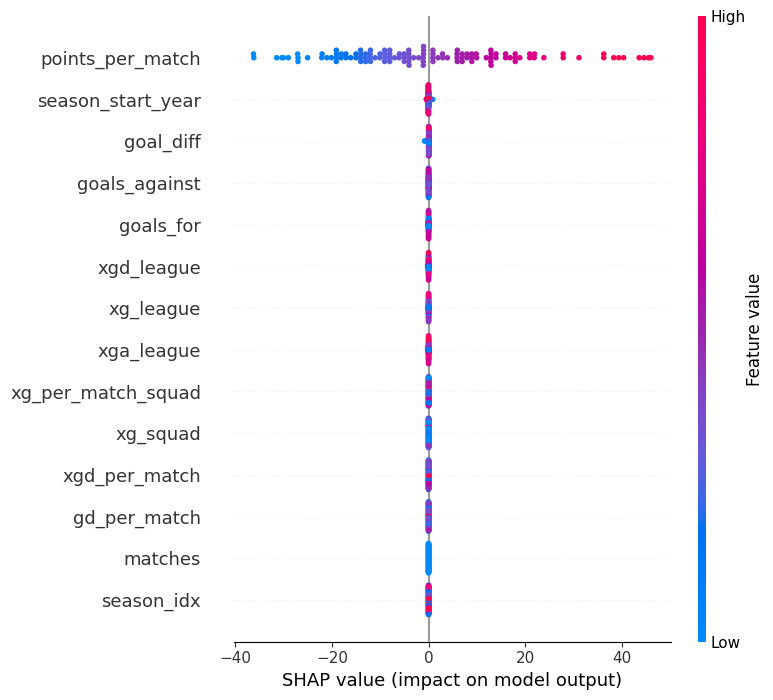

In [17]:
import shap

# Use a small sample to keep runtime reasonable
X_explain = X_train.sample(min(120, len(X_train)), random_state=42)

explainer = shap.Explainer(best_xgb, X_explain)
shap_values = explainer(X_explain)

shap.summary_plot(shap_values, X_explain)


## Comparison vs baselines

We compare Random Forest and XGBoost against the Phase 3 baselines on the same test season.


In [18]:
rows = []

# RF
rows.append({
    "model": "Phase4_RF",
    "season": test_season,
    **regression_metrics(y_test, pred_rf),
    "Spearman": ranking_metrics_by_season(rf_out, "pred_rf")[0],
    "Kendall": ranking_metrics_by_season(rf_out, "pred_rf")[1],
})

# XGB base
rows.append({
    "model": "Phase4_XGB_base",
    "season": test_season,
    **regression_metrics(y_test, pred_xgb),
    "Spearman": ranking_metrics_by_season(xgb_out, "pred_xgb")[0],
    "Kendall": ranking_metrics_by_season(xgb_out, "pred_xgb")[1],
})

# XGB tuned
rows.append({
    "model": "Phase4_XGB_tuned",
    "season": test_season,
    **regression_metrics(y_test, pred_xgb_tuned),
    "Spearman": ranking_metrics_by_season(xgb_tuned_out, "pred_xgb_tuned")[0],
    "Kendall": ranking_metrics_by_season(xgb_tuned_out, "pred_xgb_tuned")[1],
})

pd.DataFrame(rows).sort_values(["RMSE", "MAE"])


,model,season,RMSE,MAE,Spearman,Kendall
2,Phase4_XGB_tuned,2024-25,0.948870,0.300814,0.998872,0.992074
1,Phase4_XGB_base,2024-25,1.228113,0.689142,0.998872,0.992074
0,Phase4_RF,2024-25,1.497076,0.594900,0.997366,0.981463


In [19]:
import json, os

os.makedirs("data/processed", exist_ok=True)

# Save tuned predictions for test season
out = xgb_tuned_out.sort_values("pred_xgb_tuned", ascending=False)
out_path = "data/processed/phase4_test_predictions.csv"
out.to_csv(out_path, index=False)

# Save best params
params_path = "data/processed/phase4_best_xgb_params.json"
with open(params_path, "w") as f:
    json.dump(grid.best_params_, f, indent=2)

print("Saved:", out_path)
print("Saved:", params_path)


Saved: data/processed/phase4_test_predictions.csv
Saved: data/processed/phase4_best_xgb_params.json
